Found 15000 files belonging to 3 classes.
Using 12000 files for training.
Found 15000 files belonging to 3 classes.
Using 3000 files for validation.
Epoch 1/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 182s 450ms/step - accuracy: 0.7786 - loss: 0.5170 - val_accuracy: 0.3320 - val_loss: 7.8573 - learning_rate: 0.0010
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 22s 59ms/step - accuracy: 0.8828 - loss: 0.2803 - val_accuracy: 0.3443 - val_loss: 4.5322 - learning_rate: 0.0010
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - accuracy: 0.8992 - loss: 0.2521 - val_accuracy: 0.4610 - val_loss: 5.0179 - learning_rate: 0.0010
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.9013 - loss: 0.2348 - val_accuracy: 0.8680 - val_loss: 0.4445 - learning_rate: 0.0010
Epoch 5/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.9080 - loss: 0.2318 - val_accuracy: 0.3290 - val_loss: 35.4426 - learning_rate: 0.0010
Epoch 6/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.9211 - los

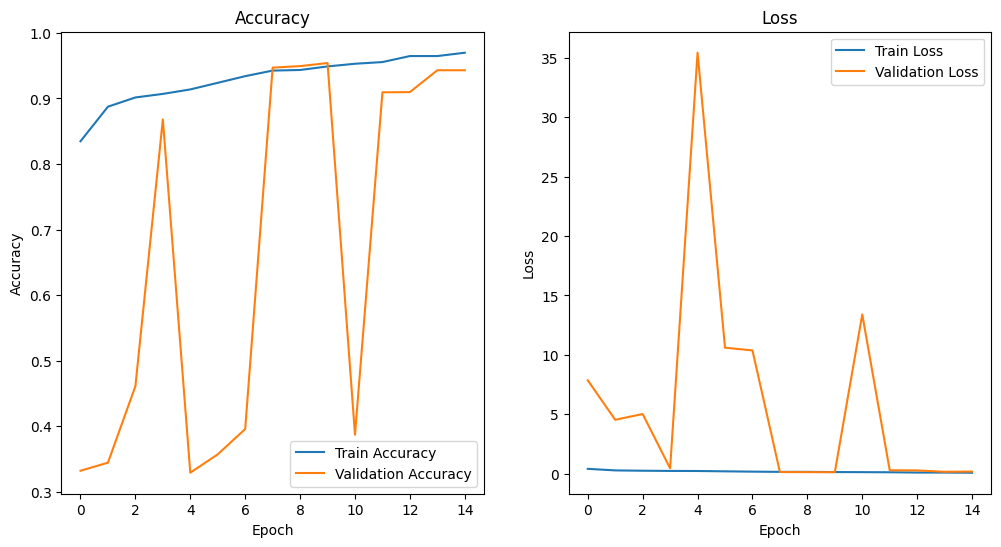

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
    BatchNormalization,
    Rescaling,
    GlobalAveragePooling2D,
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt

# Paths and parameters
dataset_path = "/kaggle/input/lung-cancer-histopathological-images"  # Kaggle dataset path
batch_size = 32
img_size = (224, 224)

# Data augmentation pipeline
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2),
        tf.keras.layers.RandomContrast(0.2),
        tf.keras.layers.RandomBrightness(0.2),
    ]
)

# Load training and validation datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
)

# Apply normalization and augmentation
train_ds = train_ds.map(lambda x, y: (data_augmentation(x) / 255.0, y))
val_ds = val_ds.map(lambda x, y: (x / 255.0, y))

# Optimize data pipeline
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Model architecture
model = Sequential([
    Rescaling(1.0 / 255, input_shape=(224, 224, 3)),  # Rescaling input
    Conv2D(32, (3, 3), activation="relu", padding="same"),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation="relu", padding="same"),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation="relu", padding="same"),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Dropout(0.3),

    Conv2D(256, (3, 3), activation="relu", padding="same"),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Dropout(0.4),

    GlobalAveragePooling2D(),  # Reduces parameters while retaining features

    Dense(512, activation="relu"),
    Dropout(0.5),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(3, activation="softmax"),  # 3 classes for classification
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

# Define callbacks
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2),
    ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss"),
]

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks,
)

# Save the final model
model.save("lung_cancer_model_final.h5")
print("Model saved as lung_cancer_model_final.h5")

# Plot training and validation metrics
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")

plt.show()
